In [228]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils import data
import os
from os import listdir
from os.path import join, abspath
import itertools
import re
import random
import time
from torch.autograd import Variable
from scipy.signal import tukey
from torch.utils import data
from tqdm.notebook import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import warnings
warnings.filterwarnings("ignore")


import json
import sqlalchemy as sal
import getpass
import pandas as pd
from urllib.request import urlopen
import pickle as pkl


In [229]:
# torch.cuda.get_device_name(0)

In [230]:
torch.cuda.is_available()

False

# Get data from RDS


In [231]:
%%time
#parameters of the AWS database
endpoint = "capstone.clihskgj8i7s.us-west-2.rds.amazonaws.com"
user="group3"
db="db1"
#pw=getpass.getpass("Enter database password")
pw=open(r'C:\Users\rmartinez4\OneDrive - Illumina, Inc\Desktop\password.txt',"r").read().rstrip()

engine = sal.create_engine('postgresql://%s:%s@%s/%s' % (user, pw, endpoint, db))

query="""
select timestamp, station, total_flow
from traffic_train
;
"""

query_data=pd.read_sql(query, engine)

print(query_data.shape)
query_data.head()

KeyboardInterrupt: 

In [7]:
print(query_data.timestamp.min(), query_data.timestamp.max())

2020-01-01 00:05:00 2020-06-30 00:00:00


In [41]:
len(query_data.station.unique())

320

In [32]:
query_data.shape

(16673264, 3)

In [42]:
%%time
# get a subset of the data
list_ = list(query_data.station.unique()[:50])
df = query_data[[i in list_ for i in query_data.station]]
df.shape

Wall time: 3min 13s


(2605095, 3)

In [44]:
df.shape

(2605095, 3)

# Data Preparation

- Data Augmentation: create more segments with a sliding window of 1 hour (12 data points)
- split into segments
- filter segments with: negative values

In [45]:
def generate_segments(df, segment_length=24, window=1):
    
    continous_time_series = []
    for s in set(df['station']):
        df_temp = df[df.station==s].sort_values('timestamp')
        for i in range(len(df_temp)-segment_length):
            arr = np.array(df_temp['total_flow'][i:i+segment_length])
            time_series = torch.from_numpy(arr.reshape(segment_length,1))
            continous_time_series.append(time_series)
        
    return torch.stack(continous_time_series, 0)

In [46]:
%%time
c_time_series = generate_segments(df)
c_time_series.shape

Wall time: 3min 1s


torch.Size([2603895, 24, 1])

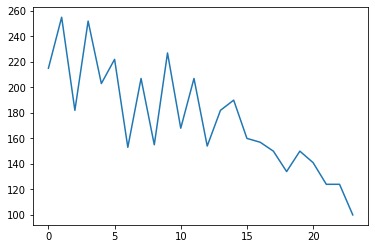

In [60]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

plt.plot(np.array(c_time_series[325053].reshape(1,24)[0]))

In [61]:
%%time
# find idx for segments with negative values and remove
n_segments = c_time_series.shape[0]
idx_to_keep = [i for i in range(n_segments) if all(c_time_series[i,:,:]>=0) and not any(c_time_series[i,:,:].isnan())]
len(idx_to_keep)

Wall time: 8min 58s


2596623

In [62]:
c_time_series = c_time_series[idx_to_keep, :, :]
c_time_series.shape

torch.Size([2596623, 24, 1])

In [65]:
filename = 'traffic_bayArea_station_mediumSize_12pts.pkl'

In [66]:
# save data

with open(filename, "wb") as fout:
    pkl.dump(c_time_series, fout, protocol=pkl.HIGHEST_PROTOCOL)

# Read Saved Data

In [279]:
# filename = '../data_traffic/traffic_bayArea_station_mediumSize_12pts.pkl'
# filename = '../data_traffic/traffic_bayArea_station_400001.pkl'
filename = '../data_traffic/traffic_bayArea_station_allStations_12pts.pkl'


In [280]:
%%time

# read tensor
with open(filename, "rb") as fout:
    c_time_series = pkl.load(fout)

Wall time: 14.2 s


In [281]:
c_time_series.shape

torch.Size([16665584, 24, 1])

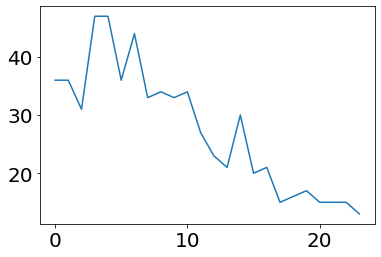

In [282]:
plt.plot(c_time_series[16665583].reshape(1,24)[0].tolist())

In [240]:
# c_time_series[5]

## Remove segments with nan values

In [283]:
# number to be removed
torch.any(c_time_series.isnan(),dim=1).sum()

tensor(47304)

In [284]:
# number to be kept
torch.any(~c_time_series.isnan(),dim=1).sum()

tensor(16665584)

In [285]:
%%time

mask_idxs = [idx for idx, val in enumerate(np.array(~torch.any(c_time_series.isnan(),dim=1))) if val]
c_time_series = c_time_series[mask_idxs, :, :]

Wall time: 8.08 s


In [286]:
c_time_series.shape

torch.Size([16618280, 24, 1])

In [288]:
# check no more nan segments are present
torch.any(c_time_series.isnan(),dim=1).sum()

tensor(0)

In [ ]:
# c_time_series[5]

# Generate Train and Test Datasets

In [289]:
def scale_data(data_x, data_y, out_pos = 0, return_current_avg_std = False):
    """ 
    Arg:
        data_x: features
        data_y: labels
        out_pos: the position of feature of which average and stand deviation will be returned.
    returns:
        1. Normalized features and labels
        2. Average and standard deviation of the selected feature.
    """
    avg = data_x[:,:,out_pos].mean()
    std = data_x[:,:,out_pos].std()
#     c_avg = data_x[:,:,1].mean()
#     c_std = data_x[:,:,1].std()
    for i in range(data_x.shape[-1]):
        data_x[:,:,i] = (data_x[:,:,i] - data_x[:,:,i].mean())/data_x[:,:,i].std()
    data_y = (data_y-avg)/std
    if return_current_avg_std:
        return data_x, data_y, (avg, std)  
#         return data_x, data_y, (avg, std), (c_avg, c_std)   
    else:
        return data_x, data_y, (avg, std)

class Dataset(data.Dataset):
    def __init__(self, X, Y, lst_index, output_steps, position_embedding = (False)):
        """
        Args:
            lst_index: indexes of observations in the dataset.
            output_steps: Forecasting Horizon.
        """
        self.X = X[lst_index]
        self.Y = Y[lst_index]
        self.output_steps = output_steps
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        x = self.X[index]
        y = self.Y[index][:self.output_steps]
        return x, y

In [290]:
%%time

sample_size = c_time_series.shape[0]
segment_size = c_time_series.shape[1]
pred_size = int(segment_size/2)

test_size = sample_size // 4
train_valid_size = test_size * 3
training_size = test_size * 2
validation_size = test_size * 1

# X_train = c_time_series[:train_valid_size,:pred_size,:]
# Y_train = c_time_series[:train_valid_size,pred_size:,:]
# sample_size, pred_length, feature_count = X_train.shape

# X_test = c_time_series[training_size:training_size+test_size,:pred_size,:]
# Y_test = c_time_series[training_size:training_size+test_size,pred_size:,:]

X_all = c_time_series[:train_valid_size+test_size,:pred_size,:]
Y_all = c_time_series[:train_valid_size+test_size,pred_size:,:]

X, Y, (avg, std) = scale_data(X_all, Y_all, out_pos = 0, return_current_avg_std = True)

Wall time: 7.49 s


In [291]:
# print(X_train.shape, Y_train.shape)
# print(X_test.shape, Y_test.shape)
print(X_all.shape, Y_all.shape)

print(sample_size, pred_length, feature_count)

print(test_size, train_valid_size, training_size, validation_size)

torch.Size([16618280, 12, 1]) torch.Size([16618280, 12, 1])
16618280 12 1
4154570 12463710 8309140 4154570


In [295]:
c_time_series[0]

tensor([[-0.9058],
        [-0.9350],
        [-0.9496],
        [-0.9496],
        [-0.9787],
        [-1.0152],
        [-0.9787],
        [-1.0371],
        [-1.0225],
        [-1.0371],
        [-1.0663],
        [-1.0444],
        [23.0000],
        [25.0000],
        [20.0000],
        [16.0000],
        [23.0000],
        [14.0000],
        [19.0000],
        [19.0000],
        [22.0000],
        [24.0000],
        [18.0000],
        [21.0000]], dtype=torch.float64)

In [294]:
X[3]

tensor([[-0.9496],
        [-0.9787],
        [-1.0152],
        [-0.9787],
        [-1.0371],
        [-1.0225],
        [-1.0371],
        [-1.0663],
        [-1.0444],
        [-1.0881],
        [-1.0736],
        [-1.1100]], dtype=torch.float64)

# Train Neural Network

In [104]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        """
        Args:
            input_dim: the dimension of input sequences.
            hidden_dim: number hidden units.
            num_layers: number of encode layers.
            dropout_rate: recurrent dropout rate.
        """
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            bidirectional = True, dropout = dropout_rate, batch_first = True)
        
    def forward(self, source):
        """
        Args:
            source: input tensor(batch_size*input dimension)
        Return:
            outputs: Prediction
            concat_hidden: hidden states
        """
        outputs, hidden = self.lstm(source)
        return outputs, hidden
    
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, dropout_rate):
        """
        Args:
            output_dim: the dimension of output sequences.
            hidden_dim: number hidden units.
            num_layers: number of code layers.
            dropout_rate: recurrent dropout rate.
        """
        super(Decoder, self).__init__()
        
        # Since the encoder is bidirectional, decoder has double hidden size
        self.lstm = nn.LSTM(output_dim, hidden_dim*2, num_layers = num_layers, 
                            dropout = dropout_rate, batch_first = True)
        
        self.out = nn.Linear(hidden_dim*2, output_dim)
      
    def forward(self, x, hidden):
        """
        Args:
            x: prediction from previous prediction.
            hidden: hidden states from previous cell.
        Returns:
            1. prediction for current step.
            2. hidden state pass to next cell.
        """
        output, hidden = self.lstm(x, hidden)   
        prediction = self.out(output.float())
        return prediction, hidden     
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        """
        Args:
            encoder: Encoder object.
            decoder: Decoder object.
            device: 
        """
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target_tensor):
        """
        Args:
            source: input tensor.
            target_length: forecasting steps.
        Returns:
            total prediction
        """
        batch_size = source.size(0) 
        input_length = source.size(1) 
        target_length = target_tensor.shape[1]
        output_dim = target_tensor.shape[-1]
        encoder_hidden = (torch.zeros(self.encoder.num_layers*2, batch_size, self.encoder.hidden_dim, device=device),
                          torch.zeros(self.encoder.num_layers*2, batch_size, self.encoder.hidden_dim, device=device))
        encoder_output, encoder_hidden = self.encoder(source)
        
        # Concatenate the hidden states of both directions.
        num_layers = int(encoder_hidden[0].shape[0]/2)
        h = torch.cat([encoder_hidden[0][0:self.encoder.num_layers,:,:], 
                       encoder_hidden[0][-self.encoder.num_layers:,:,:]], 
                      dim=2, out=None).to(device)
        c = torch.cat([encoder_hidden[1][0:self.encoder.num_layers,:,:], 
                       encoder_hidden[1][-self.encoder.num_layers:,:,:]], 
                      dim=2, out=None).to(device)
        concat_hidden = (h, c)
        
        
        outputs = torch.zeros(batch_size, target_length, output_dim).to(self.device)
        decoder_output = torch.zeros((batch_size, 1, output_dim), device = self.device)
        decoder_hidden = concat_hidden
        
        for t in range(target_length):  
            decoder_output, decoder_hidden = self.decoder(decoder_output, decoder_hidden)
            outputs[:,t:t+1,:] = decoder_output
        return outputs

In [105]:
def run_epoch_train(model, data_generator, model_optimizer, criterion):
    """
    Args:
        model: RNN model.
        data_generator: data.DataLoader object.
        model_optimizer: optimizer.
        criterion: loss function
    Returns:
        Root Mean Square Error on Training Dataset
    """
    MSE = []
    for x, y in data_generator:
        # The input shape for nn.conv1d should sequence_length * batch_size * #features
        input_tensor, target_tensor = x.to(device).float(), y.to(device).float()
        model_optimizer.zero_grad()
        loss = 0
        output = model(input_tensor, target_tensor).reshape(target_tensor.shape)
        num_iter = output.size(0)
        for ot in range(num_iter):
            loss += criterion(output[ot], target_tensor[ot])
        MSE.append(loss.item()/num_iter)
        loss.backward()
        model_optimizer.step()
    
    return round(np.sqrt(np.mean(MSE)), 5)
 

def run_epoch_eval(model, data_generator, criterion, return_pred = False):
    """
    Args:
        model: CNN model.
        data_generator: data.DataLoader object.
        criterion: loss function
    Returns:
        Root Mean Square Error on evaluation datasets.
    """
    with torch.no_grad():
        MSE = []
        preds = []
        for x, y in data_generator:
            input_tensor, target_tensor = x.to(device).float(), y.to(device).float()
            loss = 0
            output = model(input_tensor, target_tensor).reshape(target_tensor.shape)
            
            preds.append(output.cpu().detach().numpy())
            num_iter = output.size(0)
            
            for ot in range(num_iter):
                loss += criterion(output[ot], target_tensor[ot])
            MSE.append(loss.item()/num_iter)
            
    if return_pred == True:
        preds =  np.concatenate(preds).squeeze(-1)
        return round(np.sqrt(np.mean(MSE)), 5), preds
    else:
        return round(np.sqrt(np.mean(MSE)), 5)


def train_model(model, X, Y, learning_rate, output_steps, batch_size, train_idx, valid_idx, test_idx, test=False, return_pred=False):
    # Initialize the model and define optimizer, learning rate decay and criterion
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma=0.8)
    criterion = nn.MSELoss()
    
    # Split dataset into training set, validation set and test set.
    train_rmse, train_set = [], Dataset(X, Y, train_idx, output_steps)
    valid_rmse, valid_set = [], Dataset(X, Y, valid_idx, output_steps)
    if test:
        test_rmse, test_set = [], Dataset(X, Y, test_idx, output_steps)
    
    min_loss = 1000
    best_model = 0
    best_preds = 0
    min_valid_loss = 1000
    
    for i in tqdm(range(200)):
        start = time.time()
        scheduler.step()
        train_generator = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
        valid_generator = data.DataLoader(valid_set, batch_size = batch_size, shuffle = False)
        if test:
            test_generator = data.DataLoader(test_set, batch_size = batch_size, shuffle = False)
 
        model.train()
        train_rmse.append(run_epoch_train(model, train_generator, optimizer, criterion))
            
        model.eval()
        rmse, predictions = run_epoch_eval(model,  valid_generator, criterion, return_pred = True)
        valid_rmse.append(rmse)
        
        if test:
            if return_pred:
                t_rmse, test_predictions = run_epoch_eval(model, test_generator, criterion, return_pred = True)
            else:
                t_rmse = run_epoch_eval(model, test_generator, criterion, return_pred = False)
            test_rmse.append(t_rmse)
        
        if valid_rmse[-1] < min_loss:
            min_loss = valid_rmse[-1]
            best_model = model
            min_valid_loss = valid_rmse[-1]
            best_preds = predictions
            min_valid_loss = valid_rmse[-1]
            
        if (len(train_rmse) > 15 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break
            
    end = time.time()       
    print(("Epoch %d:"%(i+1)), ("Loss: %f; "%train_rmse[-1]),("valid_loss: %f; "%valid_rmse[-1]), 
          ("Time: %f; "%round(end - start,5)))

    if test:
        if return_pred:
            return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss, test_rmse, test_predictions
        return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss, test_rmse
    return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss

In [110]:
learning_rate = 0.01
dropout_rate = 0.6
num_layers = 1
hidden_dim = 128

input_size = 1
output_size = 1

In [111]:
%%time

input_steps = segment_size
output_steps = segment_size
# input_size = 2

train_idx = list(range(training_size))
valid_idx = list(range(training_size, train_valid_size))
test_idx = list(range(train_valid_size, train_valid_size + test_size))

Wall time: 73 ms


In [14]:
%%time

encoder = Encoder(input_size, hidden_dim, num_layers, dropout_rate)
decoder = Decoder(output_size, hidden_dim, num_layers, dropout_rate)
model = Seq2Seq(encoder, decoder, device).to(device)

Wall time: 7 ms


In [15]:
model

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(1, 128, batch_first=True, dropout=0.6, bidirectional=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 256, batch_first=True, dropout=0.6)
    (out): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [16]:
# print number of parameters for the model
sum(p.numel() for p in model.parameters() if p.requires_grad)

399617

In [24]:
# %%time

# model, loss, preds, min_valid_loss, test_rmse = train_model(
#     model, X, Y, learning_rate, output_steps = output_steps, batch_size = 64,
#     train_idx = train_idx, valid_idx = valid_idx, test_idx = test_idx, test=True)

# print({
#     'learning_rate': learning_rate,
#     'dropout_rate': dropout_rate,
#     'num_layers':num_layers,
#     'hidden_dim': hidden_dim,
# #     'model_state_dict': model.state_dict(),
# #     'loss': loss,
#     'min_valid_loss': min_valid_loss,
# #     'preds':preds,
# })

NameError: name 'segment_size' is not defined

In [17]:
model

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(1, 128, batch_first=True, dropout=0.6, bidirectional=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 256, batch_first=True, dropout=0.6)
    (out): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
torch.save(model, filename.split('.')[0]+'_model.pth')

# Read Saved Model

In [93]:
# model_path = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\dataaccess_station_400001\traffic_bayArea_station_400001_model.pth'
# model_path = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\scratch\model_outputs\dataaccess_mediumSize_50station\traffic_bayArea_station_mediumSize_12pts_model.pth'
model_path = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\multiple_batch_size\model_outputs\128\station_400001\trained_model.pth'

encoder = Encoder(input_size, hidden_dim, num_layers, dropout_rate)
decoder = Decoder(output_size, hidden_dim, num_layers, dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)

In [95]:
# %%time

# # load state dict
# model_dict = torch.load(model_path, map_location=torch.device('cpu'))
# model.load_state_dict(model_dict)


In [96]:
%%time

# load model object
model_obj = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(model_obj.state_dict())


Wall time: 8.03 ms


<All keys matched successfully>

In [97]:
model_obj.state_dict().keys()

odict_keys(['encoder.lstm.weight_ih_l0', 'encoder.lstm.weight_hh_l0', 'encoder.lstm.bias_ih_l0', 'encoder.lstm.bias_hh_l0', 'encoder.lstm.weight_ih_l0_reverse', 'encoder.lstm.weight_hh_l0_reverse', 'encoder.lstm.bias_ih_l0_reverse', 'encoder.lstm.bias_hh_l0_reverse', 'decoder.lstm.weight_ih_l0', 'decoder.lstm.weight_hh_l0', 'decoder.lstm.bias_ih_l0', 'decoder.lstm.bias_hh_l0', 'decoder.out.weight', 'decoder.out.bias'])

In [98]:
torch.__version__

'1.7.1'

In [99]:
 model

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(1, 128, batch_first=True, dropout=0.6, bidirectional=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 256, batch_first=True, dropout=0.6)
    (out): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [100]:
device

device(type='cpu')

# Predict on Test Data

In [114]:
%%time

test_rmse, test_set = [], Dataset(X, Y, test_idx, output_steps)
test_generator = data.DataLoader(test_set, batch_size = 128, shuffle = False)

criterion = nn.MSELoss()
model.eval()
t_rmse, preds = run_epoch_eval(model, test_generator, criterion, return_pred = True)

Wall time: 2min 18s


In [136]:
str(('fdsa'),('fdsa'))


TypeError: decoding str is not supported

In [117]:
t_rmse

0.46272

In [118]:
preds[13]

array([-1.2916093 , -1.4200467 , -1.3156741 , -1.2844567 , -1.182138  ,
       -1.205586  , -1.2392075 , -1.2362216 , -1.1846895 , -1.1674373 ,
       -1.1079984 , -1.0442511 , -0.99300534, -0.9299299 , -0.8848528 ,
       -0.76924866, -0.7639216 , -0.7279029 , -0.6135885 , -0.52191824,
       -0.4205485 , -0.3255173 , -0.19227079, -0.08562116,  0.05025107,
        0.20623127,  0.36273032,  0.46277004,  0.55207527,  0.71509206,
        0.75359637,  0.9086808 ,  1.0852861 ,  1.1122345 ,  1.3602024 ,
        1.3455286 ], dtype=float32)

# Visualize Predictions

In [119]:
# need X_test, Y_test, preds

In [120]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [121]:
def unscale_data(scaled_data, avg, std):
    data = scaled_data * std + avg
    return data

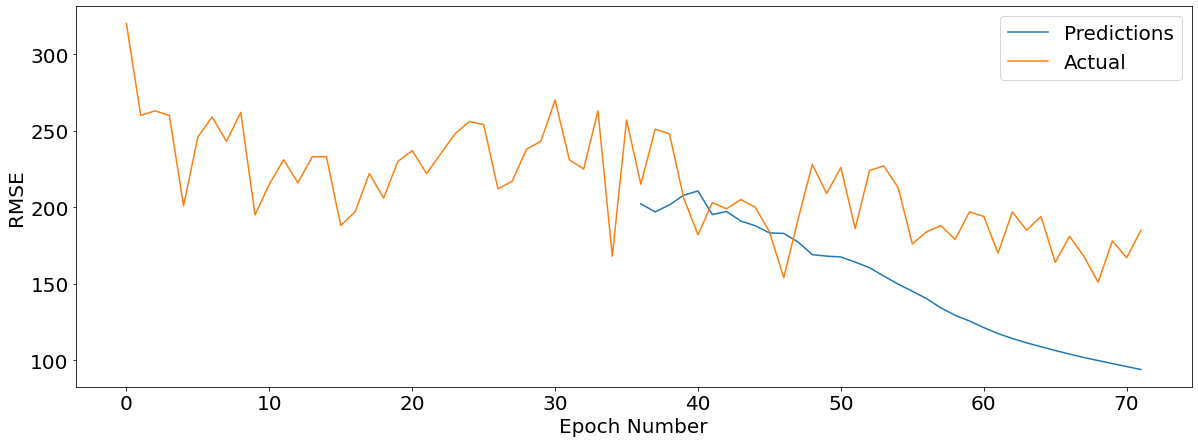

In [122]:
# first example for 3 hours
plt.figure(figsize=(20,7))
index_to_plot = 1566
plt.plot(np.concatenate(([np.nan]*pred_size, unscale_data(preds[index_to_plot], float(avg), float(std)))))
plt.plot(torch.cat([unscale_data(X_test[:,:,0][index_to_plot],float(avg), float(std)), Y_test[:,:,0][index_to_plot]]))
plt.legend(['Predictions', 'Actual'], loc='upper right')
plt.xlabel("Epoch Number")
plt.ylabel("RMSE")
plt.rcParams.update({'font.size': 20})

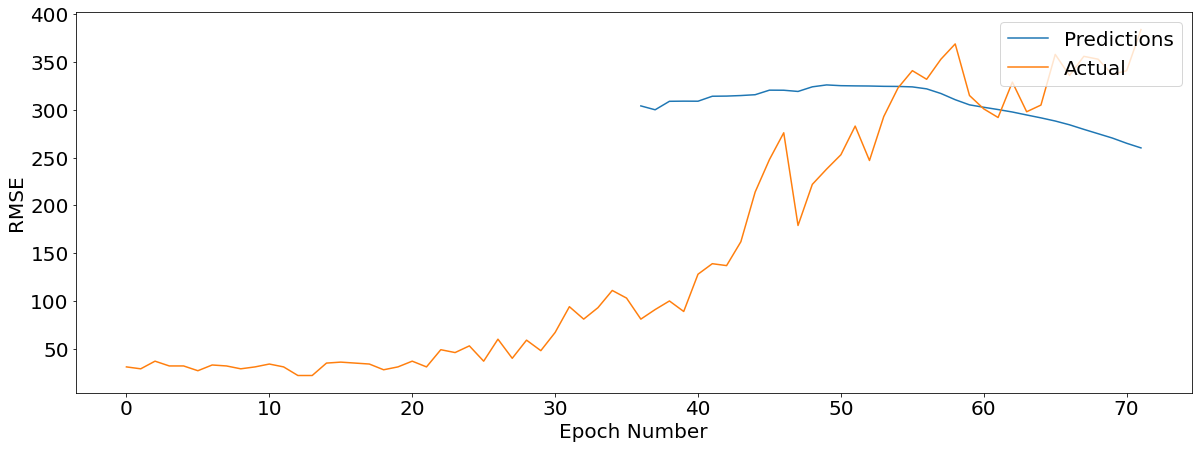

In [123]:
# second example for 3 hours
plt.figure(figsize=(20,7))
index_to_plot = 45309
plt.plot(np.concatenate(([np.nan]*pred_size, unscale_data(preds[index_to_plot], float(avg), float(std)))))
plt.plot(torch.cat([unscale_data(X_test[:,:,0][index_to_plot],float(avg), float(std)), Y_test[:,:,0][index_to_plot]]))
plt.legend(['Predictions', 'Actual'], loc='upper right')
plt.xlabel("Epoch Number")
plt.ylabel("RMSE")
plt.rcParams.update({'font.size': 20})

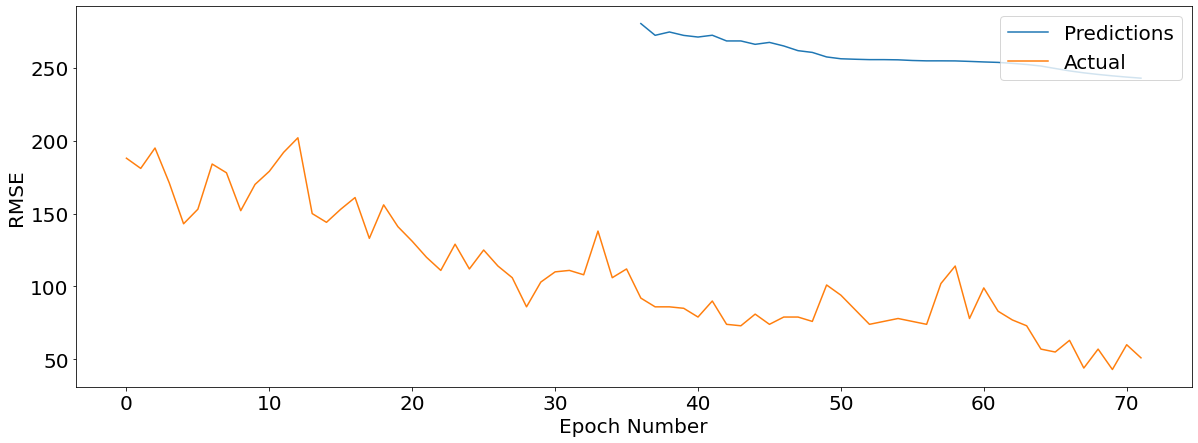

In [124]:
# third example for 3 hours
plt.figure(figsize=(20,7))
index_to_plot = 81003
plt.plot(np.concatenate(([np.nan]*pred_size, unscale_data(preds[index_to_plot], float(avg), float(std)))))
plt.plot(torch.cat([unscale_data(X_test[:,:,0][index_to_plot],float(avg), float(std)), Y_test[:,:,0][index_to_plot]]))
plt.legend(['Predictions', 'Actual'], loc='upper right')
plt.xlabel("Epoch Number")
plt.ylabel("RMSE")
plt.rcParams.update({'font.size': 20})

In [125]:
# results_fp = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\dataaccess_station_400001\traffic_bayArea_station_400001_results_dict.pkl'
# results_fp = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\dataaccess_mediumSize_50station\traffic_bayArea_station_mediumSize_12pts_results_dict.pkl'
results_fp = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\multiple_batch_size\model_outputs\128\station_400001\results_dict.pkl'

rd = pkl.load(open(results_fp, "rb"))

print(rd)

defaultdict(<class 'list'>, {'train_rmse': [0.35137, 0.32603, 0.32026, 0.3198, 0.31775, 0.32056, 0.31261, 0.33195, 0.33023, 0.36375, 0.37144, 0.37818, 0.36064, 0.33775, 0.32914, 0.3429, 0.35601, 0.33027, 0.31541, 0.31881, 0.31776, 0.31324, 0.31138, 0.30592, 0.32624], 'val_rmse': [0.61709, 0.58425, 0.60094, 0.58284, 0.53952, 0.54864, 0.60701, 0.54526, 0.59963, 0.62729, 0.61162, 0.55232, 0.54042, 0.55264, 0.49652, 0.49131, 0.54887, 0.51423, 0.59885, 0.54292, 0.55005, 0.57545, 0.54545, 0.57887, 0.55941], 'test_rmse': [0.49189, 0.45726, 0.47232, 0.47118, 0.42851, 0.44496, 0.45546, 0.46166, 0.47538, 0.50537, 0.4807, 0.4644, 0.45046, 0.46035, 0.42759, 0.41318, 0.45468, 0.42351, 0.4698, 0.46124, 0.45193, 0.47361, 0.43305, 0.46502, 0.45353]})


Test RMSE: 287.540083


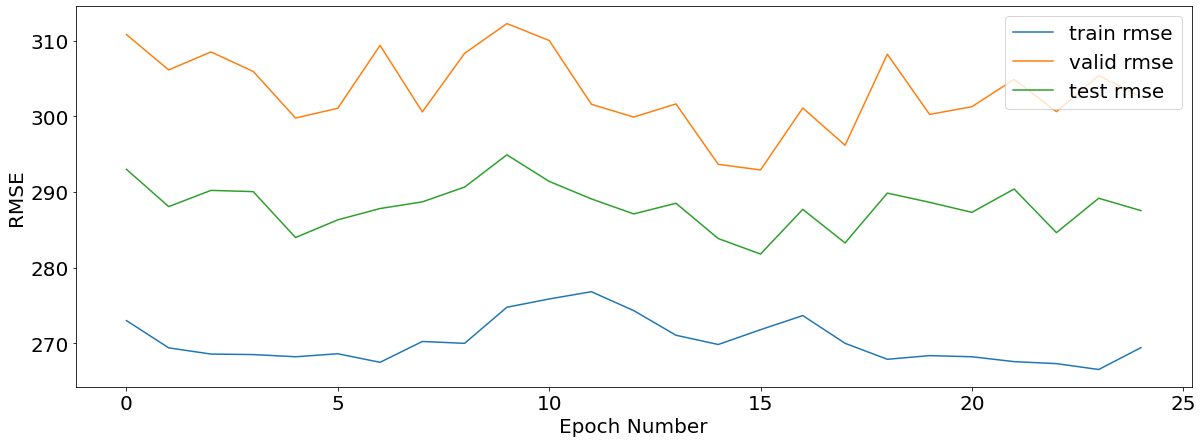

In [135]:
train_rmse = unscale_data(np.array(rd['train_rmse']),float(avg), float(std))
valid_rmse = unscale_data(np.array(rd['val_rmse']),float(avg), float(std))
test_rmse = unscale_data(np.array(rd['test_rmse']),float(avg), float(std))

plt.figure(figsize=(20,7))
plt.plot(train_rmse)
plt.plot(valid_rmse)
plt.plot(test_rmse)

plt.legend(['train rmse', 'valid rmse', 'test rmse'], loc='upper right')
plt.xlabel("Epoch Number")
plt.ylabel("RMSE")
plt.rcParams.update({'font.size': 20})

print('Test RMSE: %f' % (test_rmse[-1]) )

# Multi-GPU testing

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils import data
import os
from os import listdir
from os.path import join, abspath
import time
from torch.autograd import Variable
from torch.utils import data
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


from datetime import datetime

import pickle as pkl


############# Seq2seq functions

def scale_data(data_x, data_y, out_pos = 0, return_current_avg_std = False):
    """ 
    Arg:
        data_x: features
        data_y: labels
        out_pos: the position of feature of which average and stand deviation will be returned.
    returns:
        1. Normalized features and labels
        2. Average and standard deviation of the selected feature.
    """
    avg = data_x[:,:,out_pos].mean()
    std = data_x[:,:,out_pos].std()
#     c_avg = data_x[:,:,1].mean()
#     c_std = data_x[:,:,1].std()
    for i in range(data_x.shape[-1]):
        data_x[:,:,i] = (data_x[:,:,i] - data_x[:,:,i].mean())/data_x[:,:,i].std()
    data_y = (data_y-avg)/std
    if return_current_avg_std:
        return data_x, data_y, (avg, std)  
#         return data_x, data_y, (avg, std), (c_avg, c_std)   
    else:
        return data_x, data_y, (avg, std)

class Dataset(data.Dataset):
    def __init__(self, X, Y, lst_index, output_steps, position_embedding = (False)):
        """
        Args:
            lst_index: indexes of observations in the dataset.
            output_steps: Forecasting Horizon.
        """
        self.X = X[lst_index]
        self.Y = Y[lst_index]
        self.output_steps = output_steps
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        x = self.X[index]
        y = self.Y[index][:self.output_steps]
        return x, y
        

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        """
        Args:
            input_dim: the dimension of input sequences.
            hidden_dim: number hidden units.
            num_layers: number of encode layers.
            dropout_rate: recurrent dropout rate.
        """
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            bidirectional = True, dropout = dropout_rate, batch_first = True)
        
    def forward(self, source):
        """
        Args:
            source: input tensor(batch_size*input dimension)
        Return:
            outputs: Prediction
            concat_hidden: hidden states
        """
        outputs, hidden = self.lstm(source)
        return outputs, hidden
    
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, dropout_rate):
        """
        Args:
            output_dim: the dimension of output sequences.
            hidden_dim: number hidden units.
            num_layers: number of code layers.
            dropout_rate: recurrent dropout rate.
        """
        super(Decoder, self).__init__()
        
        # Since the encoder is bidirectional, decoder has double hidden size
        self.lstm = nn.LSTM(output_dim, hidden_dim*2, num_layers = num_layers, 
                            dropout = dropout_rate, batch_first = True)
        
        self.out = nn.Linear(hidden_dim*2, output_dim)
      
    def forward(self, x, hidden):
        """
        Args:
            x: prediction from previous prediction.
            hidden: hidden states from previous cell.
        Returns:
            1. prediction for current step.
            2. hidden state pass to next cell.
        """
        output, hidden = self.lstm(x, hidden)   
        prediction = self.out(output.float())
        return prediction, hidden     
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        """
        Args:
            encoder: Encoder object.
            decoder: Decoder object.
            device: 
        """
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target_tensor):
        """
        Args:
            source: input tensor.
            target_length: forecasting steps.
        Returns:
            total prediction
        """
        batch_size = source.size(0) 
        input_length = source.size(1) 
        target_length = target_tensor.shape[1]
        output_dim = target_tensor.shape[-1]
        encoder_hidden = (torch.zeros(self.encoder.num_layers*2, batch_size, self.encoder.hidden_dim, device=device),
                          torch.zeros(self.encoder.num_layers*2, batch_size, self.encoder.hidden_dim, device=device))
        encoder_output, encoder_hidden = self.encoder(source)
        
        # Concatenate the hidden states of both directions.
        num_layers = int(encoder_hidden[0].shape[0]/2)
        h = torch.cat([encoder_hidden[0][0:self.encoder.num_layers,:,:], 
                       encoder_hidden[0][-self.encoder.num_layers:,:,:]], 
                      dim=2, out=None).to(device)
        c = torch.cat([encoder_hidden[1][0:self.encoder.num_layers,:,:], 
                       encoder_hidden[1][-self.encoder.num_layers:,:,:]], 
                      dim=2, out=None).to(device)
        concat_hidden = (h, c)
        
        
        outputs = torch.zeros(batch_size, target_length, output_dim).to(self.device)
        decoder_output = torch.zeros((batch_size, 1, output_dim), device = self.device)
        decoder_hidden = concat_hidden
        
        for t in range(target_length):  
            decoder_output, decoder_hidden = self.decoder(decoder_output, decoder_hidden)
            outputs[:,t:t+1,:] = decoder_output
        return outputs


def run_epoch_train(model, data_generator, model_optimizer, criterion):
    """
    Args:
        model: RNN model.
        data_generator: data.DataLoader object.
        model_optimizer: optimizer.
        criterion: loss function
    Returns:
        Root Mean Square Error on Training Dataset
    """
    MSE = []
    for x, y in data_generator:
        # The input shape for nn.conv1d should sequence_length * batch_size * #features
        input_tensor, target_tensor = x.to(device).float(), y.to(device).float()
        model_optimizer.zero_grad()
        loss = 0
        output = model(input_tensor, target_tensor).reshape(target_tensor.shape)
        num_iter = output.size(0)
        for ot in range(num_iter):
            loss += criterion(output[ot], target_tensor[ot])
        MSE.append(loss.item()/num_iter)
        loss.backward()
        model_optimizer.step()
    
    return round(np.sqrt(np.mean(MSE)), 5)
 

def run_epoch_eval(model, data_generator, criterion, return_pred = False):
    """
    Args:
        model: CNN model.
        data_generator: data.DataLoader object.
        criterion: loss function
    Returns:
        Root Mean Square Error on evaluation datasets.
    """
    with torch.no_grad():
        MSE = []
        preds = []
        for x, y in data_generator:
            input_tensor, target_tensor = x.to(device).float(), y.to(device).float()
            loss = 0
            output = model(input_tensor, target_tensor).reshape(target_tensor.shape)
            preds.append(output.cpu().detach().numpy())
            num_iter = output.size(0)
            
            for ot in range(num_iter):
                loss += criterion(output[ot], target_tensor[ot])
            MSE.append(loss.item()/num_iter)
            
    if return_pred == True:
        preds =  np.concatenate(preds).squeeze(-1)
        return round(np.sqrt(np.mean(MSE)), 5), preds
    else:
        return round(np.sqrt(np.mean(MSE)), 5)


def train_model(model, X, Y, learning_rate, output_steps, batch_size, train_idx, valid_idx, test_idx, test=False, return_pred=False):
    # Initialize the model and define optimizer, learning rate decay and criterion
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma=0.8)
    criterion = nn.MSELoss()
    
    # Split dataset into training set, validation set and test set.
    train_rmse, train_set = [], Dataset(X, Y, train_idx, output_steps)
    valid_rmse, valid_set = [], Dataset(X, Y, valid_idx, output_steps)
    if test:
        test_rmse, test_set = [], Dataset(X, Y, test_idx, output_steps)
    
    min_loss = 1000
    best_model = 0
    best_preds = 0
    min_valid_loss = 1000
    
    # for i in tqdm(range(200)):
    for i in range(200):
        
        print(i, datetime.now())
        
        start = time.time()
        scheduler.step()
        train_generator = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
        valid_generator = data.DataLoader(valid_set, batch_size = batch_size, shuffle = False)
        if test:
            test_generator = data.DataLoader(test_set, batch_size = batch_size, shuffle = False)
 
        model.train()
        train_rmse.append(run_epoch_train(model, train_generator, optimizer, criterion))
            
        model.eval()
        rmse, predictions = run_epoch_eval(model,  valid_generator, criterion, return_pred = True)
        valid_rmse.append(rmse)
        
        if test:
            if return_pred:
                t_rmse, test_predictions = run_epoch_eval(model, test_generator, criterion, return_pred = True)
            else:
                t_rmse = run_epoch_eval(model, test_generator, criterion, return_pred = False)
            test_rmse.append(t_rmse)
        
        if valid_rmse[-1] < min_loss:
            min_loss = valid_rmse[-1]
            best_model = model
            min_valid_loss = valid_rmse[-1]
            best_preds = predictions
            min_valid_loss = valid_rmse[-1]
            
        if (len(train_rmse) > 15 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break
            
    end = time.time()       
    print(("Epoch %d:"%(i+1)), ("Loss: %f; "%train_rmse[-1]),("valid_loss: %f; "%valid_rmse[-1]), 
          ("Time: %f; "%round(end - start,5)))

    if test:
        if return_pred:
            return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss, test_rmse, test_predictions
        return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss, test_rmse
    return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss


############# Main

print('Code started', datetime.now())

# base_dir = r'C:\Users\rmartinez4\Box\Personal Git\dse-capstone\seq2seq_example\data_traffic'
base_dir = r'C:\Users\rmartinez4\Box\Personal Git\dse-capstone\seq2seq_example\data_traffic'

filename = 'traffic_bayArea_station_400001.pkl'

# read tensor
with open(join(base_dir, filename), "rb") as fout:
    c_time_series = pkl.load(fout)

sample_size = c_time_series.shape[0]
segment_size = c_time_series.shape[1]
pred_size = int(segment_size/2)

test_size = sample_size // 5
train_valid_size = test_size * 4
training_size = test_size * 7//2
validation_size = test_size * 1//2

print(' sample_size', sample_size, '\n',
      'train_valid_size', train_valid_size, '\n',
      'training_size', training_size, '\n',
      'validation_size', validation_size, '\n',
      'test_size', test_size)

X_all = c_time_series[:train_valid_size+test_size,:pred_size,:]
Y_all = c_time_series[:train_valid_size+test_size,pred_size:,:]

X, Y, (avg, std) = scale_data(X_all, Y_all, out_pos = 0, return_current_avg_std = True)


learning_rate = 0.01
dropout_rate = 0.6
num_layers = 1
hidden_dim = 128

input_steps = segment_size
output_steps = segment_size
input_size = 1
output_size = 1

train_idx = list(range(training_size))
valid_idx = list(range(training_size, train_valid_size))
test_idx = list(range(train_valid_size, train_valid_size + test_size))

encoder = Encoder(input_size, hidden_dim, num_layers, dropout_rate)
decoder = Decoder(output_size, hidden_dim, num_layers, dropout_rate)

# to enable multi GPU training
# rank = dist.get_rank()
# world_size = dist.get_world_size()
# print('rank {} and world size {}'.format(rank, world_size))

# os.environ['MASTER_ADDR'] = 'localhost'
# os.environ['MASTER_PORT'] = '12355'
# dist.init_process_group("gloo", rank=0, world_size=2)


# init_method="/some_file"
init_method='env://'
dist.init_process_group(
   "gloo",
   rank=0,
   init_method=init_method,
   world_size=2)

print('Hello')

model = Seq2Seq(encoder, decoder, rank).to(rank)
model = DDP(model, device_ids=[rank])

model, loss, preds, min_valid_loss, test_rmse = train_model(
    model, X, Y, learning_rate, output_steps = output_steps, batch_size = 64,
    train_idx = train_idx, valid_idx = valid_idx, test_idx = test_idx, test=True)

results_dict = {
    'learning_rate': learning_rate,
    'dropout_rate': dropout_rate,
    'num_layers':num_layers,
    'hidden_dim': hidden_dim,
    # 'model_state_dict': model.state_dict(),
    'train_rmse': loss[0],
    'valid_rmse': loss[1],
    'test_rmse': test_rmse,
    'min_valid_loss': min_valid_loss
    # 'preds':preds
}


# read saved model
# model = torch.load(r'C:\Users\rmartinez4\Box\Personal Git\dse-capstone\seq2seq_example\Nautilus\models\traffic_bayArea_station_400001_model.pth', map_location=torch.device('cpu'))

# save results dict and model
# file_id = filename.split('.')[0]
# with open(base_dir + file_id + '_results_dict.pkl', 'wb') as handle:
# # with open(join(base_dir, file_id + '_results_dict.pkl'), 'wb') as handle:
#     pkl.dump(results_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)

# torch.save(model, base_dir + file_id + '_model.pth')
# torch.save(model, join(base_dir, file_id + '_model.pth'))




cpu
Code started 2021-04-20 13:50:33.063228
 sample_size 327725 
 train_valid_size 262180 
 training_size 229407 
 validation_size 32772 
 test_size 65545


RuntimeError: No rendezvous handler for env://